In [1]:
%cd ..

/home/gianscarpe/dev/event-camera


In [3]:
from experimenting.dataset import DHP3DDataset, get_dataloader
from experimenting.dataset.indexes import get_dataset_params
from experimenting.utils import get_file_paths, decay_heatmap
from matplotlib import pyplot as plt
from os.path import join, basename
import numpy as np
from albumentations import Compose, CenterCrop
from albumentations.pytorch import ToTensor
import torch
from omegaconf import DictConfig
from experimenting.utils import get_file_paths, get_preload_dir, get_label_from_filename
import cv2

%matplotlib inline

## 

In [4]:
# Augmentation
aug = Compose([CenterCrop(256, 256), ToTensor()])

In [5]:
data_dir = '/data/dhp19/time_count_dataset/movements_per_frame'
labels_dir = '/data/dhp19/time_count_dataset/labels'

hparams = DictConfig({'path': data_dir, 'labels_dir' : labels_dir})
file_paths, train_index, val_index, test_index, _ = get_dataset_params(hparams)

LOADED INDEXES! train: 56137 	 val: 14035 	 test: 17543


In [27]:
d = DHP3DDataset(file_paths, labels_dir, val_index, transform=aug)
loader = get_dataloader(d, 32, 2)

In [7]:
def display(img):          
        fig, ax = plt.subplots(ncols=img.shape[0], nrows=1,                              
                               figsize=(20,20))                                                                                   
        for i in range(img.shape[0]):                                                                
            ax[i].imshow(img[i])                                                  
            ax[i].axis('off')
        plt.show()

In [28]:
batch = next(iter(loader))
x, y = batch

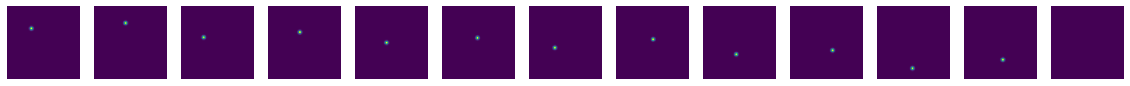

In [29]:
display(y[4].numpy())


## Try Loaded model for 2d heatmap prediction

In [42]:
import experimenting.models as models
from importlib import reload
import experimenting.utils as utils
import pytorch_lightning as pl
import os
import experimenting.models.metrics as metrics
from importlib import reload
mp = metrics.MPJPE()

exp_name = 'exp_Adam_0.0003_center_crop_05-13-09-53_05-13-09-53'
checkpoint_dir = f'/home/gianscarpe/dev/exps/timecount_pose/exps_PoseEstimator/exps_unet_resnet18/{exp_name}/checkpoints'
checkpoints = sorted(os.listdir(checkpoint_dir))
checkpoint_path = os.path.join(checkpoint_dir, checkpoints[0])
model = models.PoseEstimator.load_from_checkpoint(checkpoint_path)
model = model.eval()

In [35]:
with torch.no_grad():

    #model.model.segmentation_head[-1] = torch.nn.Identity()
    preds = model(x)

In [36]:
gt_joints, _ = utils.get_joints_from_heatmap(y)
p_joints, p_conf = utils.get_joints_from_heatmap(preds)

In [43]:
import experimenting.models.dsnt as dsnt

In [46]:
p_joints[0]

tensor([[ 42., 113.],
        [ 75., 102.],
        [  3., 124.],
        [ 10.,   0.],
        [ 96., 131.],
        [122., 111.],
        [115., 131.],
        [255.,   1.],
        [ 86., 139.],
        [164., 112.],
        [158., 134.],
        [  0.,   0.],
        [193., 141.]])

In [85]:
preds.sum(0).shape

torch.Size([13, 256, 256])

In [88]:
hm = (preds - preds.mean()) / preds.std()

In [116]:
o = torch.linspace(0, 256, 255)
print(o.shape)
o.view(-1, o.size(-1)).shape

torch.Size([255])


torch.Size([1, 255])

In [135]:
heatmaps.dim()

4

In [128]:
dim_range = range(-1, 1 - preds.dim(), -1)
for dim in dim_range:
    print(dim)

-1
-2


In [144]:
32 * 13

416

In [129]:
heatmaps = preds
dim = -1

In [138]:
preds.shape

torch.Size([32, 13, 256, 256])

In [165]:
dim_size = heatmaps.size()[dim]
own_coords = dsnt._normalized_linspace(dim_size, dtype=heatmaps.dtype, device=heatmaps.device)

        
summed = heatmaps.view(-1, *heatmaps.size()[2:])

In [166]:
own_coords.shape
own_coords = torch.linspace(0, 256, 256)
o.shape

torch.Size([256])

In [167]:
for i in range(2 - heatmaps.dim(), 0):
    if i != dim:
        summed = summed.sum(i, keepdim=True)

In [168]:
summed = summed.view(summed.size(0), -1)

In [180]:
def soft_argmax(voxels):
	"""
	Arguments: voxel patch in shape (batch_size, channel, H, W, depth)
	Return: 3D coordinates in shape (batch_size, channel, 3)
	"""
	assert voxels.dim()==5
	# alpha is here to make the largest element really big, so it
	# would become very close to 1 after softmax
	alpha = 1000.0 
	N,C,H,W,D = voxels.shape
	soft_max = nn.functional.softmax(voxels.view(N,C,-1)*alpha,dim=2)
	soft_max = soft_max.view(voxels.shape)
	indices_kernel = torch.arange(start=0,end=H*W*D).unsqueeze(0)
	indices_kernel = indices_kernel.view((H,W,D))
	conv = soft_max*indices_kernel
	indices = conv.sum(2).sum(2).sum(2)
	z = indices%D
	y = (indices/D).floor()%W
	x = (((indices/D).floor())/W).floor()%H
	coords = torch.stack([x,y,z],dim=2)
	return coords

In [182]:
beta = 12
y_est = np.array([[1.1, 3.0, 1.1, 1.3, 0.8]])
a = np.exp(beta*y_est)
b = np.sum(np.exp(beta*y_est))
softmax = a/b
max = np.sum(softmax*y_est)
print(max)
pos = range(y_est.size)
softargmax = np.sum(softmax*pos)
print(softargmax)

2.9999999971674023
1.0000000027735394


In [241]:
import experimenting.models.soft_argmax as soft_argmax
reload(soft_argmax)

<module 'experimenting.models.soft_argmax' from '/home/gianscarpe/dev/event-camera/experimenting/models/soft_argmax.py'>

In [242]:
s = soft_argmax.SoftArgmax2D(window_fn = "Parzen")

In [248]:
s(dsnt.flat_softmax(preds.cuda()))[0]

tensor([[ 42.0000, 113.0000],
        [ 75.0000, 102.0000],
        [  3.0123, 124.0000],
        [ 10.0000,   0.8567],
        [ 96.0000, 131.0000],
        [122.0000, 111.0000],
        [115.0000, 131.0000],
        [254.1342,   1.3867],
        [ 86.0000, 139.0000],
        [164.0000, 112.0000],
        [158.0000, 134.0000],
        [254.1372, 254.1372],
        [193.0000, 141.0000]], device='cuda:0')

In [246]:
p_joints[0]

tensor([[ 42., 113.],
        [ 75., 102.],
        [  3., 124.],
        [ 10.,   0.],
        [ 96., 131.],
        [122., 111.],
        [115., 131.],
        [255.,   1.],
        [ 86., 139.],
        [164., 112.],
        [158., 134.],
        [  0.,   0.],
        [193., 141.]])

In [188]:
hm = dsnt.flat_softmax(preds)

In [197]:
dsnt.dsnt(hm)[0]

tensor([[-2.2446e-04, -1.3012e-03],
        [-3.8498e-04, -7.5092e-04],
        [-6.6771e-05, -8.0197e-04],
        [-3.7585e-04, -2.8583e-04],
        [ 6.9524e-05, -4.9573e-04],
        [-2.4179e-04, -8.3549e-05],
        [ 5.3866e-05, -1.7291e-04],
        [-1.4522e-05,  1.4748e-05],
        [ 1.8452e-04, -6.2497e-04],
        [-2.2744e-04,  5.7129e-04],
        [ 7.7988e-05,  4.1119e-04],
        [ 0.0000e+00,  0.0000e+00],
        [ 2.1517e-04,  8.9701e-04]])

In [200]:
dsnt.dsnt(y)[0]

tensor([[-11.3875, -66.3614],
        [-20.0262, -41.2305],
        [  0.3927, -45.1572],
        [-32.5917, -21.5969],
        [ -1.1780, -23.1676],
        [-12.1728,  -4.3194],
        [  2.7487,  -9.8168],
        [-17.6702, -41.2305],
        [  9.8168, -31.0210],
        [-12.1728,  30.2357],
        [  4.3194,  24.7383],
        [-13.7435,  60.0787],
        [ 10.6021,  49.8693]])

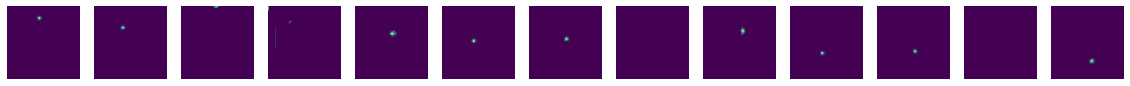

In [190]:
display(hm[0])

In [175]:

#expectations = summed.mul(own_coords.view(-1, own_coords.size(-1))).sum(-1)
expectations = summed.sum(-1).view(*heatmaps.size()[:2])

In [179]:
p_joints[0]

tensor([[ 42., 113.],
        [ 75., 102.],
        [  3., 124.],
        [ 10.,   0.],
        [ 96., 131.],
        [122., 111.],
        [115., 131.],
        [255.,   1.],
        [ 86., 139.],
        [164., 112.],
        [158., 134.],
        [  0.,   0.],
        [193., 141.]])

In [178]:
expectations[0]

tensor([ 99.4418,  94.9441,  46.0706,  28.1918, 111.1117,  96.1828,  93.1061,
          0.8928, 107.3682,  98.6433,  88.6119,   0.0000,  96.2705])

In [109]:
o = torch.linspace(0, 256, 255)
expectations = summed.mul(o.view(-1, o.size(-1))).sum(-1)

tensor([[-11.3875, -66.3614],
        [-20.0262, -41.2305],
        [  0.3927, -45.1572],
        [-32.5917, -21.5969],
        [ -1.1780, -23.1676],
        [-12.1728,  -4.3194],
        [  2.7487,  -9.8168],
        [-17.6702, -41.2305],
        [  9.8168, -31.0210],
        [-12.1728,  30.2357],
        [  4.3194,  24.7383],
        [-13.7435,  60.0787],
        [ 10.6021,  49.8693]])

In [107]:
dsnt.euclidean_losses(dsnt.dsnt(y), dsnt.dsnt(preds)).mean()

tensor(13.7968)

In [105]:
dsnt.dsnt(y)[0]

tensor([[-11.3875, -66.3614],
        [-20.0262, -41.2305],
        [  0.3927, -45.1572],
        [-32.5917, -21.5969],
        [ -1.1780, -23.1676],
        [-12.1728,  -4.3194],
        [  2.7487,  -9.8168],
        [-17.6702, -41.2305],
        [  9.8168, -31.0210],
        [-12.1728,  30.2357],
        [  4.3194,  24.7383],
        [-13.7435,  60.0787],
        [ 10.6021,  49.8693]])

In [69]:
c = (dsnt.dsnt(hm)[0] - dsnt.dsnt(preds)[0].mean() ) / dsnt.dsnt(preds)[0].std()

In [75]:
cnn = c * p_joints[0].std() + p_joints[0].mean()

In [92]:
dsnt.dsnt(hm)

tensor([[[-5.7550e+02, -3.3375e+03],
         [-9.9769e+02, -1.9432e+03],
         [-1.9540e+02, -2.2451e+03],
         [-1.1113e+03, -8.2814e+02],
         [ 1.9734e+02, -1.3845e+03],
         [-6.2663e+02, -2.1765e+02],
         [ 1.4313e+02, -4.6175e+02],
         [-4.3843e+01,  4.4534e+01],
         [ 4.9919e+02, -1.6907e+03],
         [-5.7153e+02,  1.4406e+03],
         [ 2.0336e+02,  1.0718e+03],
         [-6.6757e-06, -9.5367e-06],
         [ 5.9081e+02,  2.4537e+03]],

        [[-6.9677e+02, -3.2920e+03],
         [-1.1771e+03, -1.7140e+03],
         [-1.9682e+02, -2.0626e+03],
         [-6.2152e+02, -5.8863e+02],
         [-3.0206e+02, -1.1009e+03],
         [-6.0409e+02, -1.8353e+02],
         [ 3.8692e+00, -5.7477e+02],
         [-3.2217e+01,  3.2589e+01],
         [ 3.1000e+02, -2.0155e+02],
         [-1.2111e+02,  1.3773e+03],
         [ 3.9484e+02,  9.8854e+02],
         [-6.6757e-06, -9.5367e-06],
         [-9.4210e+00,  1.1636e+03]],

        [[-3.0559e+02, -2.6896e+03

In [37]:
def plot_2d(dvs_frame, sample_gt, sample_pred):
    " To plot image and 2D ground truth and prediction "
    plt.figure()
    plt.imshow(dvs_frame, cmap='gray')
    plt.plot(sample_gt[:,1], sample_gt[:,0], '.', c='red', label='gt')
    plt.plot(sample_pred[:,1], sample_pred[:,0], '.', c='blue', label='pred')
    plt.legend()

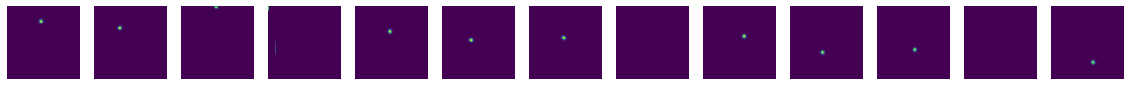

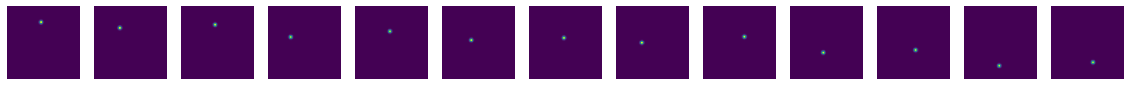

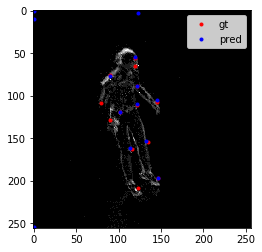

In [38]:
display(preds[2].numpy())
display(y[2].numpy())
plot_2d(x[2].squeeze(), gt_joints[2], p_joints[2])

/home/gianscarpe/anaconda3/envs/event-camera/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


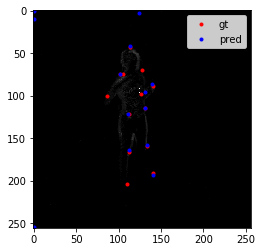

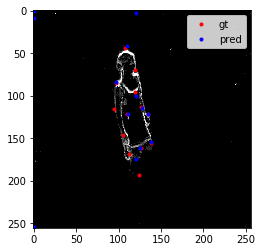

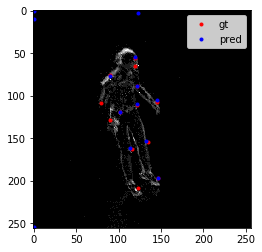

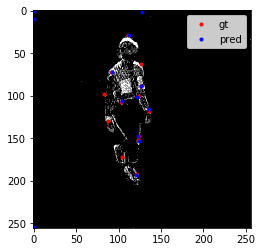

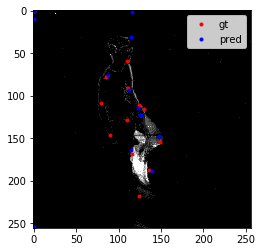

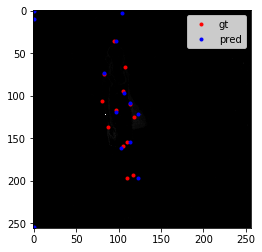

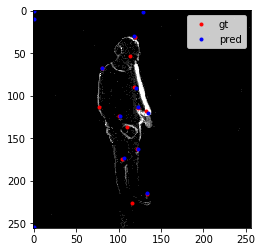

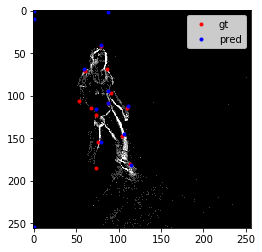

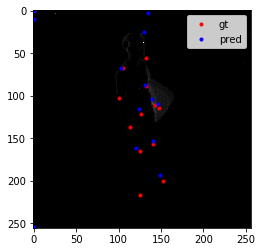

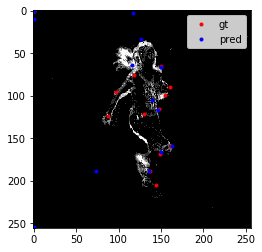

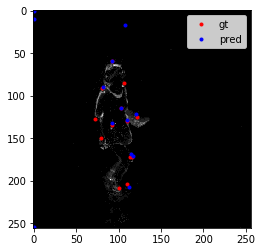

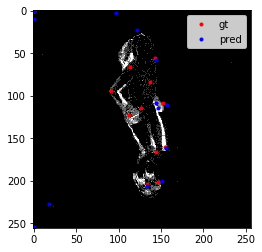

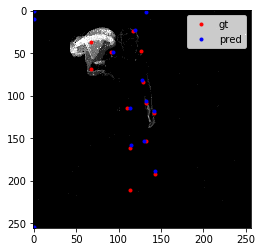

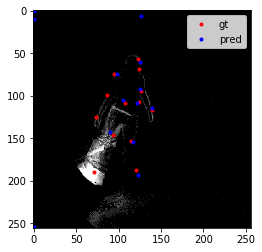

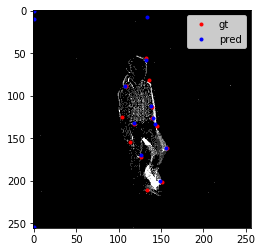

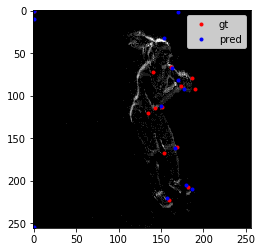

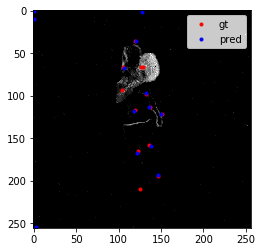

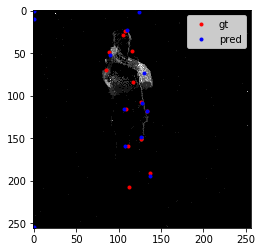

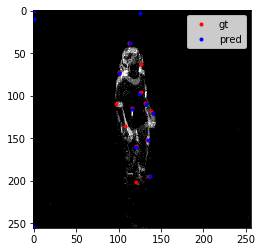

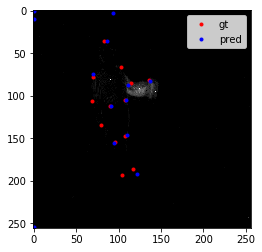

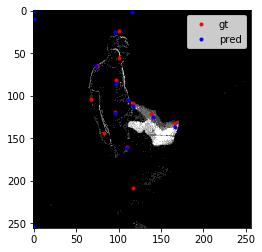

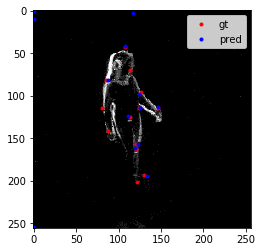

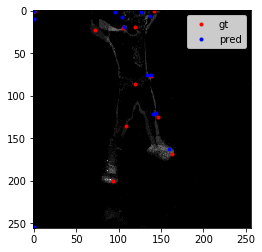

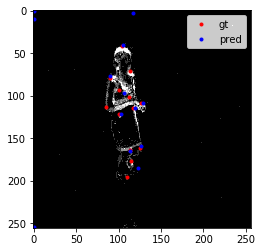

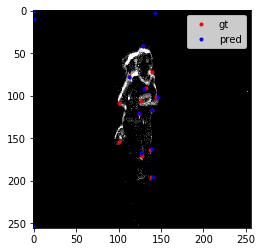

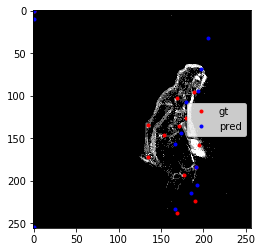

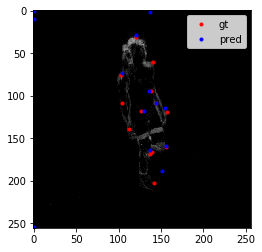

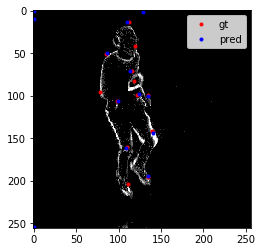

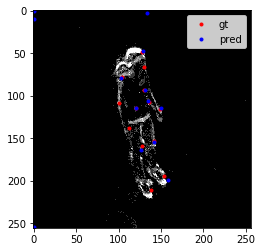

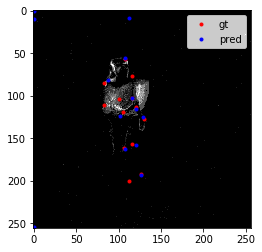

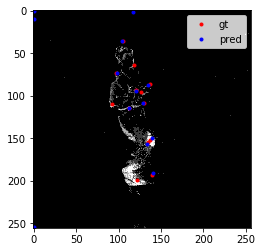

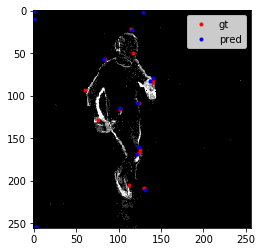

In [39]:
for i in range(0, 32):
    plot_2d(x[i].squeeze(), gt_joints[i], p_joints[i])